In [ ]:
# ===== 1. Install & Imports =====
!pip install --quiet --upgrade scikit-learn imbalanced-learn

import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 62.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.

In [2]:
# Visualization Settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

# ===== Create Results Folder =====
results_dir = "./Res-Task-1-Level-3"
os.makedirs(results_dir, exist_ok=True)


In [3]:
# ===== 2. Load Dataset =====
train_path = "/kaggle/input/churn-prdiction-data/Churn-Prdiction-Data/churn-bigml-80.csv"
test_path = "/kaggle/input/churn-prdiction-data/Churn-Prdiction-Data/churn-bigml-20.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print("✅ Data Loaded Successfully")
print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")

df_train.head()



✅ Data Loaded Successfully
Train shape: (2666, 20), Test shape: (667, 20)


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
# ===== 3. Preprocessing =====
# Drop customerID if exists
if "customerID" in df_train.columns:
    df_train.drop("customerID", axis=1, inplace=True)
    df_test.drop("customerID", axis=1, inplace=True)

# Encode categorical variables
label_encoders = {}
for col in df_train.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])
    label_encoders[col] = le

# Split Features & Labels
X_train = df_train.drop("Churn", axis=1)
y_train = df_train["Churn"]
X_test = df_test.drop("Churn", axis=1)
y_test = df_test["Churn"]

# Standard Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [5]:
# ===== 4. Apply SMOTE =====
print("⚡ Applying SMOTE to balance classes...")
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print(f"🔍 After SMOTE: {np.bincount(y_train)}")


⚡ Applying SMOTE to balance classes...
🔍 After SMOTE: [2278 2278]


In [6]:
# ===== 5. Train Random Forest =====
rf = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="f1", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_


Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [7]:
# ===== 6. Evaluation =====
y_pred = best_model.predict(X_test)
train_pred = best_model.predict(X_train)

train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring="accuracy")
cv_mean = np.mean(cv_scores)
cm = confusion_matrix(y_test, y_pred)

importances = best_model.feature_importances_
features = df_train.drop("Churn", axis=1).columns
feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)


In [8]:
# ===== Display Results =====
print("="*50)
print("📊 Classification Report:\n")
print(class_report)
print("="*50)
print("✅ Best Parameters:", best_params)
print(f"✅ Train Accuracy: {train_accuracy:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print(f"✅ Cross-Validation Accuracy (Mean): {cv_mean:.4f}")
print(f"✅ Cross-Validation Scores: {cv_scores}")
print("="*50)



📊 Classification Report:

              precision    recall  f1-score   support

       False       0.97      0.97      0.97       572
        True       0.79      0.81      0.80        95

    accuracy                           0.94       667
   macro avg       0.88      0.89      0.88       667
weighted avg       0.94      0.94      0.94       667

✅ Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
✅ Train Accuracy: 0.9607
✅ Test Accuracy: 0.9430
✅ Cross-Validation Accuracy (Mean): 0.9320
✅ Cross-Validation Scores: [0.90679825 0.94621295 0.92535675 0.9363337  0.94511526]


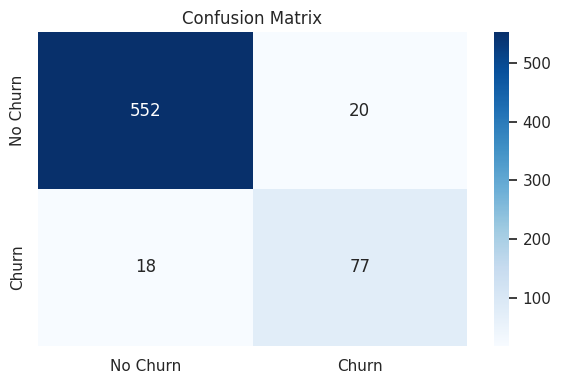

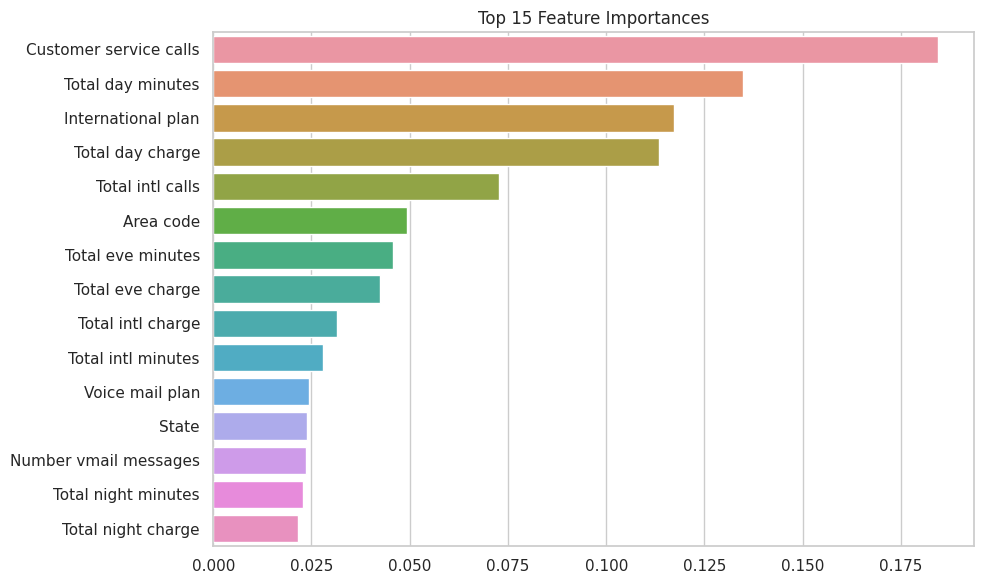

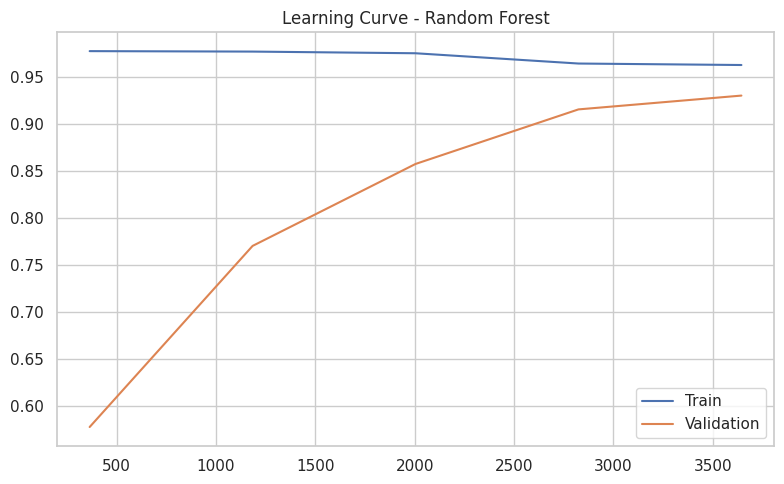

In [9]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "Confusion_Matrix.png"))
plt.show()

# Feature Importances
plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances[:15], y=feat_importances.index[:15])
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "Feature_Importance.png"))
plt.show()

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring="accuracy")
plt.figure(figsize=(8,5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Train")
plt.plot(train_sizes, np.mean(val_scores, axis=1), label="Validation")
plt.legend()
plt.title("Learning Curve - Random Forest")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "Learning_Curve.png"))
plt.show()


In [10]:
# ===== Save Outputs =====
with open(os.path.join(results_dir, "classification_report.txt"), "w", encoding="utf-8") as f:
    f.write("📊 Classification Report:\n")
    f.write(class_report)

with open(os.path.join(results_dir, "results_acc.txt"), "w", encoding="utf-8") as f:
    f.write(f"✅ Best Parameters: {best_params}\n")
    f.write(f"✅ Train Accuracy: {train_accuracy:.4f}\n")
    f.write(f"✅ Test Accuracy: {test_accuracy:.4f}\n")
    f.write(f"✅ Cross-Validation Accuracy: {cv_mean:.4f}\n")

with open(os.path.join(results_dir, "feature_importances.txt"), "w", encoding="utf-8") as f:
    f.write(str(feat_importances.head(15)))

# Save Model & Preprocessors
joblib.dump(best_model, os.path.join(results_dir, "random_forest_model.pkl"))
joblib.dump(scaler, os.path.join(results_dir, "scaler.pkl"))
joblib.dump(label_encoders, os.path.join(results_dir, "label_encoders.pkl"))
print("✅ Model & Files Saved!")


✅ Model & Files Saved!
